In [1]:
!nvidia-smi

Fri Mar 18 09:00:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install datasets transformers

     |████████████████████████████████| 325 kB 791 kB/s            
     |████████████████████████████████| 212 kB 12.2 MB/s            


In [3]:
!wget -O train_en.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_en.jsonl.bz2
!wget -O test_en.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/test_en.jsonl.bz2

!bzip2 -dk train_en.jsonl.bz2
!bzip2 -dk test_en.jsonl.bz2

!ls -l

--2022-03-18 09:00:37--  https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_en.jsonl.bz2
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_en.jsonl.bz2 [following]
--2022-03-18 09:00:38--  https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_en.jsonl.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21191431 (20M) [application/octet-stream]
Saving to: ‘train_en.jsonl.bz2’

train_en.jsonl.bz2  100%[===================>]  20.21M  --.-KB/s    in 0.1s    

2022-03-18 09:00:38 (171 MB/s) - ‘train_en.jsonl.bz

In [4]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

output_dir = "./results-base"
#output_dir = "./drive/MyDrive/utu/kandi/results1"
checkpoint_dir = None # "./results/checkpoint-15000"
tokenizer_name = "bert-base-uncased"
# tokenizer_name = "TurkuNLP/bert-base-finnish-cased-v1"
labels = ["label_identity_attack", "label_insult", "label_obscene", "label_severe_toxicity", "label_threat", "label_toxicity"]

device

'cuda:0'

In [5]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("WANDB_API_KEY")

os.environ['WANDB_API_KEY'] = wandb_key

In [6]:
import numpy as np
from datasets import load_dataset, Dataset

dataset = load_dataset('json', data_files={'train': 'train_en.jsonl', 'test': 'test_en.jsonl'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-ba67c28d8f5a5aab/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'id': ['ee9697785fe41ff8', '29fec512f2ee929e', '88944b29dde50648', 'c7bf1f59096102f3', '7d71ee0e8ea0794a'], 'label_identity_attack': [0, 0, 0, 0, 0], 'label_insult': [0, 0, 0, 0, 0], 'label_obscene': [0, 0, 0, 0, 0], 'label_severe_toxicity': [0, 0, 0, 0, 0], 'label_threat': [0, 0, 0, 0, 0], 'label_toxicity': [0, 0, 0, 0, 0], 'lang': ['en-orig', 'en-orig', 'en-orig', 'en-orig', 'en-orig'], 'text': ['"\nThanks Xeno. -  • Talk • "', '2009 (UTC)\nFixed    03:36, 8 June', 'Question\nWhat was wrong with the repair I did?', "I agree myself now, actually. (Amazing how the deniars can't admit their mistakes!!)", 'Kisumu \n\nI saw that you contributed to Kisumu, I was wondering whether we could work together to update the Kisumu page which currently reads like a travel brochure, which is very undeserving for a leading town in East Africa. If possible could you constructively help me make it better, I am hoping to get together a work group of contributers to help out so that it is something clos

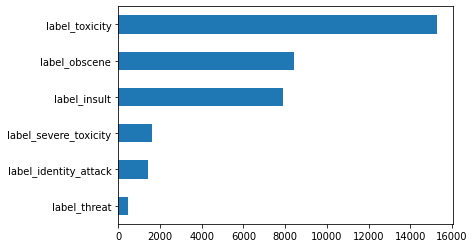

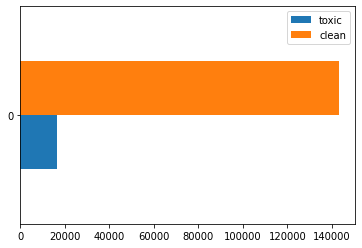

In [7]:
import pandas as pd

df_pandas = pd.DataFrame(dataset['train'])
df_pandas[labels].sum().sort_values().plot(kind="barh");

train_toxic = df_pandas[df_pandas[labels].sum(axis=1) > 0]
train_clean = df_pandas[df_pandas[labels].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');


#train_df = pd.concat([
#  train_toxic,
#  train_clean.sample(40_000, random_state=123)
#])

# shuffle
#dataset['train'] = Dataset.from_pandas(train_df.sample(frac=1, random_state=123))

print(dataset['train'][:5])
print(dataset)

In [8]:
print(len(train_toxic))
print(len(train_clean))

16225
143346


In [9]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

def preprocess(items):
    return tokenizer(items["text"], truncation=True)

ds = dataset.remove_columns(["id", "lang"])
ds = ds.map(lambda it: {'labels': torch.FloatTensor([it[label] for label in labels])})
ds = ds.remove_columns(labels)
tokenized_data = ds.map(preprocess, batched=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/159571 [00:00<?, ?ex/s]

  0%|          | 0/63978 [00:00<?, ?ex/s]

  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/64 [00:00<?, ?ba/s]

In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
tokenized_data['train'][0]

{'text': '"\nThanks Xeno. -  • Talk • "',
 'labels': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'input_ids': [101,
  1000,
  4283,
  1060,
  16515,
  1012,
  1011,
  1528,
  2831,
  1528,
  1000,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback

model = None
if checkpoint_dir is not None:
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir)
else:
  model = AutoModelForSequenceClassification.from_pretrained(
                                                           tokenizer_name,
                                                           num_labels=len(labels),
                                                           problem_type="multi_label_classification",
                                                           id2label={int(i): v for i, v in enumerate(labels)},
                                                           label2id={str(v): i for i, v in enumerate(labels)},
                                                          )
# model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
from sklearn.utils import class_weight

class_counts = [v for v in df_pandas[labels].sum()]
pos_weights = np.ones_like(class_counts)

neg_counts = [len(dataset['train']) - count for count in class_counts]
print("i", "pos.", "neg.")
for i, (pos, neg) in enumerate(zip(class_counts,  neg_counts)):
    print(i, pos, neg)
    pos_weights[i] = neg / pos

class_weights = pos_weights
class_weights

i pos. neg.
0 1405 158166
1 7877 151694
2 8449 151122
3 1595 157976
4 478 159093
5 15294 144277


array([112,  19,  17,  99, 332,   9])

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import expit as sigmoid
from torch import nn

def compute_metrics(pred):
    y_act = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    
    print(y_pred)
    print("--------")
    print(y_act)
    
    print("--------")
    print(classification_report(y_act, y_pred, target_names=labels))
    print("--------")
    
    metrics = classification_report(y_act, y_pred, output_dict=True)
    metrics["avg_f1"] = metrics["weighted avg"]["f1-score"]
    return metrics    

class_weights = torch.tensor(class_weights).to(device)

class CustomTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs['logits']
        loss_func = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss
    

training_args = TrainingArguments(
    output_dir=output_dir + "-2e-mult-16b-pos-weight",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1.3, # TODO
    weight_decay=0.01,
    evaluation_strategy="steps",
    warmup_steps=500,
    eval_steps=2500,
    save_steps=2500,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_avg_f1"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

if checkpoint_dir is not None:
    trainer.train(checkpoint_dir)
else:
    trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 159571
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 12967
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: toppev (use `wandb login --relogin` to force relogin)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss,Validation Loss,0,1,2,3,4,5,Micro avg,Macro avg,Weighted avg,Samples avg,Avg F1
2500,0.584000,0.405846,"{'precision': 0.21555633065922566, 'recall': 0.8679775280898876, 'f1-score': 0.34534786253143335, 'support': 712}","{'precision': 0.3077139112525744, 'recall': 0.9591479428071199, 'f1-score': 0.4659437238642002, 'support': 3427}","{'precision': 0.4062680698508153, 'recall': 0.9517745868328367, 'f1-score': 0.5694602042470417, 'support': 3691}","{'precision': 0.08191126279863481, 'recall': 0.9809264305177112, 'f1-score': 0.15119697606047877, 'support': 367}","{'precision': 0.13068592057761733, 'recall': 0.8578199052132701, 'f1-score': 0.2268170426065163, 'support': 211}","{'precision': 0.40938704028021017, 'recall': 0.9596059113300492, 'f1-score': 0.5739258531794746, 'support': 6090}","{'precision': 0.32669049253272114, 'recall': 0.952062353428059, 'f1-score': 0.4864579111526194, 'support': 14498}","{'precision': 0.25858708923651297, 'recall': 0.9295420507984792, 'f1-score': 0.3887819437481908, 'support': 14498}","{'precision': 0.3626948796459344, 'recall': 0.952062353428059, 'f1-score': 0.5202862854012965, 'support': 14498}","{'precision': 0.05866886533912699, 'recall': 0.09125610887075765, 'f1-score': 0.06831010339638305, 'support': 14498}",0.520286
5000,0.488800,0.420774,"{'precision': 0.36983729662077597, 'recall': 0.8300561797752809, 'f1-score': 0.5116883116883116, 'support': 712}","{'precision': 0.34100614519320904, 'recall': 0.9553545374963525, 'f1-score': 0.5026097635861222, 'support': 3427}","{'precision': 0.43962336175085887, 'recall': 0.9360606881603901, 'f1-score': 0.5982683982683982, 'support': 3691}","{'precision': 0.17147351861562665, 'recall': 0.8910081743869209, 'f1-score': 0.287598944591029, 'support': 367}","{'precision': 0.33072407045009783, 'recall': 0.8009478672985783, 'f1-score': 0.4681440443213296, 'support': 211}","{'precision': 0.4178526137804706, 'recall': 0.9738916256157636, 'f1-score': 0.5847958982449221, 'support': 6090}","{'precision': 0.38539388842164285, 'recall': 0.9481997516898882, 'f1-score': 0.5480385903364694, 'support': 14498}","{'precision': 0.34508616773517314, 'recall': 0.8978865121222145, 'f1-score': 0.4921842267833521, 'support': 14498}","{'precision': 0.39536750042167973, 'recall': 0.9481997516898882, 'f1-score': 0.5559876274016181, 'support': 14498}","{'precision': 0.06736299978117478, 'recall': 0.09187481113299363, 'f1-score': 0.07446669979493763, 'support': 14498}",0.555988
7500,0.428000,0.406543,"{'precision': 0.3955892487939352, 'recall': 0.8061797752808989, 'f1-score': 0.5307443365695792, 'support': 712}","{'precision': 0.3921616656460502, 'recall': 0.9343449080828713, 'f1-score': 0.5524499654934437, 'support': 3427}","{'precision': 0.44357976653696496, 'recall': 0.9265781630994311, 'f1-score': 0.5999473730374527, 'support': 3691}","{'precision': 0.1524229074889868, 'recall': 0.9427792915531336, 'f1-score': 0.2624194160030338, 'support': 367}","{'precision': 0.2881619937694704, 'recall': 0.8767772511848341, 'f1-score': 0.4337631887456037, 'support': 211}","{'precision': 0.42934980021794406, 'recall': 0.9704433497536946, 'f1-score': 0.5953160412994207, 'support': 6090}","{'precision': 0.4010528482780931, 'recall': 0.9406124982756242, 'f1-score': 0.5623389208469928, 'support': 14498}","{'precision': 0.35021089707555864, 'recall': 0.9095171231591439, 'f1-score': 0.49577338685808897, 'support': 14498}","{'precision': 0.4134592469760884, 'recall': 0.9406124982756242, 'f1-score': 0.5724133262020084, 'support': 14498}","{'precision': 0.06820052726458053, 'recall': 0.09086430752237748, 'f1-score': 0.07470041559650487, 'support': 14498}",0.572413
10000,0.329300,0.362585,"{'precision': 0.376905041031653, 'recall': 0.9030898876404494, 'f1-score': 0.5318444995864351, 'support': 712}","{'precision': 0.4287446120689655, 'recall': 0.9288007003209805, 'f1-score': 0.5866740392590545, 'support': 3427}","{'precision': 0.4493090533384993, 'recall': 0.9425629910593335, 'f1-score

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
--------
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
--------
                       precision    recall  f1-score   support

label_identity_attack       0.22      0.87      0.35       712
         label_insult       0.31      0.96      0.47      3427
        label_obscene       0.41      0.95      0.57      3691
label_severe_toxicity       0.08      0.98      0.15       367
         label_threat       0.13      0.86      0.23       211
       label_toxicity       0.41      0.96      0.57      6090

            micro avg       0.33      0.95      0.49     14498
            macro avg       0.26      0.93      0.39     14498
         weighted avg       0.36      0.95      0.52     14498
          samples avg       0.06      0.09      0.07     14498

--------


Saving model checkpoint to ./results-base-2e-mult-16b-pos-weight/checkpoint-2500
Configuration saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-2500/config.json
Model weights saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-2500/tokenizer_config.json
Special tokens file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-2500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1.]]
--------
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
--------
                       precision    recall  f1-score   support

label_identity_attack       0.37      0.83      0.51       712
         label_insult       0.34      0.96      0.50      3427
        label_obscene       0.44      0.94      0.60      3691
label_severe_toxicity       0.17      0.89      0.29       367
         label_threat       0.33      0.80      0.47       211
       label_toxicity       0.42      0.97      0.58      6090

            micro avg       0.39      0.95      0.55     14498
            macro avg       0.35      0.90      0.49     14498
         weighted avg       0.40      0.95      0.56     14498
          samples avg       0.07      0.09      0.07     14498

--------


Saving model checkpoint to ./results-base-2e-mult-16b-pos-weight/checkpoint-5000
Configuration saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-5000/config.json
Model weights saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-5000/tokenizer_config.json
Special tokens file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-5000/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]]
--------
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
--------
                       precision    recall  f1-score   support

label_identity_attack       0.40      0.81      0.53       712
         label_insult       0.39      0.93      0.55      3427
        label_obscene       0.44      0.93      0.60      3691
label_severe_toxicity       0.15      0.94      0.26       367
         label_threat       0.29      0.88      0.43       211
       label_toxicity       0.43      0.97      0.60      6090

            micro avg       0.40      0.94      0.56     14498
            macro avg       0.35      0.91      0.50     14498
         weighted avg       0.41      0.94      0.57     14498
          samples avg       0.07      0.09      0.07     14498

--------


Saving model checkpoint to ./results-base-2e-mult-16b-pos-weight/checkpoint-7500
Configuration saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-7500/config.json
Model weights saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-7500/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-7500/tokenizer_config.json
Special tokens file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-7500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]]
--------
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
--------
                       precision    recall  f1-score   support

label_identity_attack       0.38      0.90      0.53       712
         label_insult       0.43      0.93      0.59      3427
        label_obscene       0.45      0.94      0.61      3691
label_severe_toxicity       0.18      0.93      0.30       367
         label_threat       0.33      0.87      0.48       211
       label_toxicity       0.48      0.95      0.64      6090

            micro avg       0.43      0.94      0.59     14498
            macro avg       0.37      0.92      0.52     14498
         weighted avg       0.44      0.94      0.60     14498
          samples avg       0.07      0.09      0.07     14498

--------


Saving model checkpoint to ./results-base-2e-mult-16b-pos-weight/checkpoint-10000
Configuration saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-10000/config.json
Model weights saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-10000/tokenizer_config.json
Special tokens file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-10000/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]]
--------
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
--------
                       precision    recall  f1-score   support

label_identity_attack       0.40      0.86      0.55       712
         label_insult       0.47      0.90      0.62      3427
        label_obscene       0.47      0.93      0.62      3691
label_severe_toxicity       0.18      0.92      0.30       367
         label_threat       0.34      0.86      0.49       211
       label_toxicity       0.47      0.96      0.63      6090

            micro avg       0.45      0.93      0.60     14498
            macro avg       0.39      0.90      0.53     14498
         weighted avg       0.46      0.93      0.61     14498
          samples avg       0.07      0.09      0.08     14498

--------


Saving model checkpoint to ./results-base-2e-mult-16b-pos-weight/checkpoint-12500
Configuration saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-12500/config.json
Model weights saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-12500/pytorch_model.bin
tokenizer config file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-12500/tokenizer_config.json
Special tokens file saved in ./results-base-2e-mult-16b-pos-weight/checkpoint-12500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results-base-2e-mult-16b-pos-weight/checkpoint-12500 (score: 0.6102760320284905).


In [15]:
#!zip -r ./checkpoint.zip ./results/checkpoint-12000